In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import timedelta
import pytz
from pytz import timezone
%matplotlib inline

In [2]:
# Construct two data frames
# One called dfCBL collect all informations for CBL file
# The other called dfNBBO collect all informations for CBL-NBBO file
dates = ['01', '02', '03', '06', '07', '08', '09', '10', '13', '14', '15', '16', 
        '17', '20', '21', '22', '23', '24', '27', '28', '29', '30']

def mytimeparser1(x):
    if (len(x) == 8):
        return dt.datetime.strptime(x + ".000", '%H:%M:%S.%f').replace(tzinfo=pytz.UTC).time()
    elif (len(x) == 5):
        return dt.datetime.strptime(x + ":00.000", '%H:%M:%S.%f').replace(tzinfo=pytz.UTC).time()
    else:
        return dt.datetime.strptime(x, '%H:%M:%S.%f').replace(tzinfo=pytz.UTC).time()

dfCBL = pd.read_csv('CBL.2008-10-01', delimiter = '|', 
                    names = ('symbology','date','time','price','size','exchange',
                             'saleconditions','iscorrection','iscancel','isopen','isclose'),
                    parse_dates=['time'], date_parser = mytimeparser1)
    
for date in dates[1:]:
    newdf = pd.read_csv('CBL.2008-10-' + date, delimiter = '|', 
                        names = ('symbology','date','time','price','size','exchange',
                                 'saleconditions','iscorrection','iscancel','isopen','isclose'),
                        parse_dates=['time'], date_parser = mytimeparser1)
    dfCBL = pd.concat([dfCBL, newdf], ignore_index=True)

In [3]:
dfNBBO = pd.read_csv('CBL-NBBO.2008-10-01', delimiter = '|', 
                     names = ('symbology','timestamp','exchange','bidprice','bidsize',
                              'askprice','asksize','bestbidprice','bestbidsize','bestaskprice','bestasksize'),
                     encoding = "iso-8859-1", parse_dates = ['timestamp'] )

for date in dates[1:]:
    newdf = pd.read_csv('CBL-NBBO.2008-10-' + date, delimiter = '|', 
                      names = ('symbology','timestamp','exchange','bidprice','bidsize',
                               'askprice','asksize','bestbidprice','bestbidsize','bestaskprice','bestasksize'),
                      encoding = "iso-8859-1", parse_dates = ['timestamp'] )
    dfNBBO = pd.concat([dfNBBO, newdf], ignore_index=True)

dfNBBO['timestamp'] = dfNBBO['timestamp'].dt.tz_convert('US/Eastern')
dfNBBO['time'] = dfNBBO['timestamp'].dt.time

In [6]:
# Work for problem 2.2
# Extract all columns that can be used to tag trade
timeCBL = dfCBL['time']
priceCBL = dfCBL['price']
dateCBL = dfCBL['date']
dateNBBO = dfNBBO['timestamp']
timeNBBO = dfNBBO['time']
bidNBBO = dfNBBO['bestbidprice']
askNBBO = dfNBBO['bestaskprice']

# Initialize an array of to record tag
length = len(priceCBL)
tradeCBL = [0] * length

# This function determine the trade given trade price and corresponding quote
# @input:
# currPrice: trade price
# bidPrice: bid price for the quote
# askPrice: ask price for the quote
# i: the index of the trade, specifying the order
# quote: a boolean to tell if we can do quote test, true means can, false means cannot
# @return: a tag that specify trade as "Buy" or "Sell" or "Cannot tell"
def tradeTag(currPrice, bidPrice, askPrice, i, quote):
    if (askPrice > bidPrice and quote): # check if spread exist and we can do quote test
        # spread exists, so apply quote test first, use midPrice as the classification price
        midPrice = (askPrice + bidPrice) / 2.0
        if (currPrice > midPrice):
            return "Buy"
        elif (currPrice < midPrice):
            return "Sell"
        else: # price equal to midPrice, apply tick test, find uptick or downtick
            prevI = i - 1
            # find a previous price that is different from current price
            while (priceCBL[prevI] == priceCBL[i] and prevI >= 1):
                prevI -= 1
            if (priceCBL[i] > priceCBL[prevI]):
                return "Buy"
            elif (priceCBL[i] < priceCBL[prevI]):
                return "Sell"
            else:
                # No previous price different from current price, tick test still fail
                return "Cannot tell"
    else:
        # spread does not exist or cannot do quote test, directly apply tick test
        prevI = i - 1
        # find a previous price that is different from current price
        while (priceCBL[prevI] == priceCBL[i] and prevI >= 1):
            prevI -= 1
        if (priceCBL[i] > priceCBL[prevI]):
            return "Buy"
        elif (priceCBL[i] < priceCBL[prevI]):
            return "Sell"
        else:
            # No previous price different from current price, tick test still fail
            return "Cannot tell"

j = 0 # j is the index in dfNBBO
for i in range(length): # i is the index in dfCBL
    if (not i):
        # current time and trade price
        currTime = timeCBL[i]
        currPrice = priceCBL[i]
        # find the quote whose time is before current time
        while ((currTime.second - timeNBBO[j + 1].second) + 60 * (currTime.minute - timeNBBO[j + 1].minute) 
               + 3600 * (currTime.hour - timeNBBO[j + 1].hour) >= 0):
            j += 1
        # record quote information
        bidPrice, askPrice = bidNBBO[j], askNBBO[j]
        # check if this quote could be the prevailing quote
        if ((currTime.second - timeNBBO[j + 1].second) + 60 * (currTime.minute - timeNBBO[j + 1].minute) 
               + 3600 * (currTime.hour - timeNBBO[j + 1].hour) <= 1):
            # this quote could be the prevailing quote, we can apply quote test
            tradeCBL[i] = tradeTag(currPrice, bidPrice, askPrice, i, True)
        else:
            # this quote could not be the prevailing quote, we cannot apply quote test
            tradeCBL[i] = tradeTag(currPrice, bidPrice, askPrice, i, False)
    else:
        # check if the date is changed
        if (dateCBL[i] != dateCBL[i - 1]):
            # if the date is changed, move j to the beginning of new date
            day = dt.datetime.strptime(dateCBL[i], '%Y-%m-%d').day
            while (dateNBBO[j].day < day):
                j += 1
            # current time and trade price
            currTime = timeCBL[i]
            currPrice = priceCBL[i]
            # check if the first quote of this date is before first trade
            if ((currTime.second - timeNBBO[j].second) + 60 * (currTime.minute - timeNBBO[j].minute) 
                   + 3600 * (currTime.hour - timeNBBO[j].hour) < 0):
                # the first quote of this date is after first trade, so no prevailing quote, cannot apply quote test
                bidPrice, askPrice = bidNBBO[j], askNBBO[j]
                tradeCBL[i] = tradeTag(currPrice, bidPrice, askPrice, i, False)
            else:
                # the first quote of this date is before first trade, prevailing quote may exist
                # find the quote whose time is before current time
                while ((currTime.second - timeNBBO[j + 1].second) + 60 * (currTime.minute - timeNBBO[j + 1].minute) 
                       + 3600 * (currTime.hour - timeNBBO[j + 1].hour) >= 0):
                    j += 1
                # record quote information
                bidPrice, askPrice = bidNBBO[j], askNBBO[j]
                # check if this quote could be the prevailing quote
                if ((currTime.second - timeNBBO[j + 1].second) + 60 * (currTime.minute - timeNBBO[j + 1].minute) 
                       + 3600 * (currTime.hour - timeNBBO[j + 1].hour) <= 1):
                    # this quote could be the prevailing quote, we can apply quote test
                    tradeCBL[i] = tradeTag(currPrice, bidPrice, askPrice, i, True)
                else:
                    # this quote could not be the prevailing quote, we cannot apply quote test
                    tradeCBL[i] = tradeTag(currPrice, bidPrice, askPrice, i, False)
        else:
            # current time and trade price
            currTime = timeCBL[i]
            currPrice = priceCBL[i]
            # find the quote whose time is before current time
            while ((currTime.second - timeNBBO[j + 1].second) + 60 * (currTime.minute - timeNBBO[j + 1].minute) 
                    + 3600 * (currTime.hour - timeNBBO[j + 1].hour) >= 0 and dateNBBO[j + 1].day == dateNBBO[j].day):
                j += 1
            # check if this quote could be the prevailing quote
            if ((currTime.second - timeNBBO[j + 1].second) + 60 * (currTime.minute - timeNBBO[j + 1].minute) 
                    + 3600 * (currTime.hour - timeNBBO[j + 1].hour) <= 1):
                # this quote could be the prevailing quote, we can apply quote test
                tradeCBL[i] = tradeTag(currPrice, bidPrice, askPrice, i, True)
            else:
                # this quote could not be the prevailing quote, we cannot apply quote test
                tradeCBL[i] = tradeTag(currPrice, bidPrice, askPrice, i, False)

In [7]:
# print results
print("Number of trades that tagged as buy =", tradeCBL.count("Buy"))
print("Number of trades that tagged as sell =", tradeCBL.count("Sell"))
# convert the tag array as a column of the data frame tradeCBL
dfCBL['tradeTag'] = tradeCBL 
dfCBL

Number of trades that tagged as buy = 76202
Number of trades that tagged as sell = 189857


In [8]:
# Work for problem 2.3
# initial delta and mu
delta, mu = [0.5], 0.05

# update delta by the tag we have
for i in range(1, length):
    if (tradeCBL[i] == "Buy"):
        nextDelta = delta[-1]*((1-mu)/(-2*delta[-1]*mu + mu + 1))
        delta.append(nextDelta)
    else:
        nextDelta = delta[-1]*((1 + mu)/(2*delta[-1]*mu - mu + 1))
        delta.append(nextDelta)
        
# construct an array to display date time for each trade
dateTimeCBL = [dt.datetime.combine(dt.datetime.strptime(dateCBL[i], '%Y-%m-%d'), timeCBL[i]) for i in range(length)]

Text(0.5, 1.0, 'The actual price')

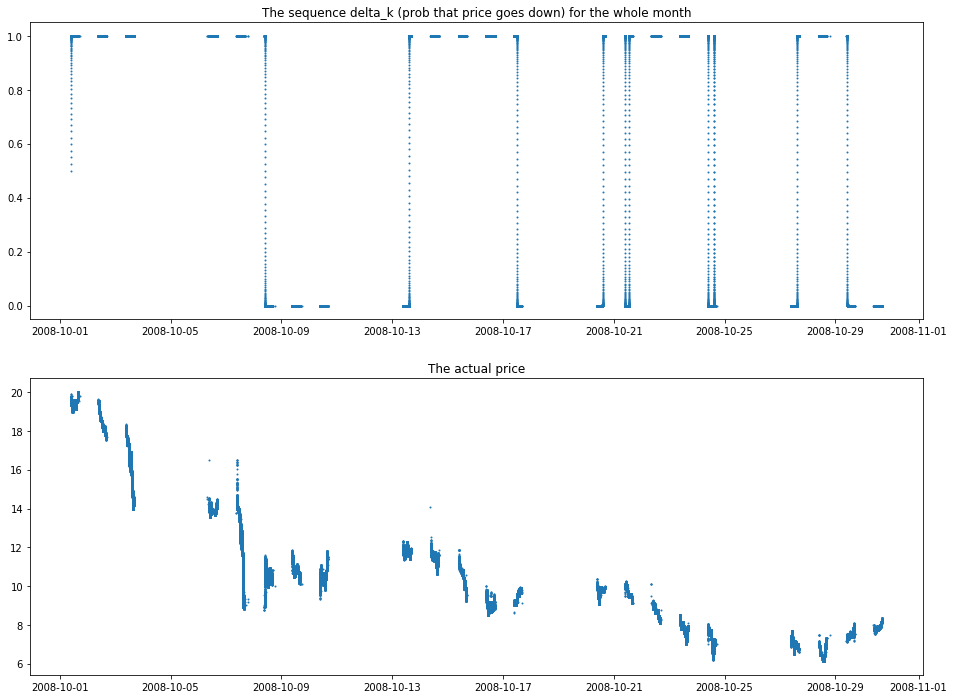

In [10]:
# plot results
fig = plt.figure(figsize = (16,12))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212, sharex = ax1)
ax1.plot_date(x = dateTimeCBL, y = delta, markersize = 1)
ax2.plot_date(x = dateTimeCBL, y = priceCBL, markersize = 1)
ax1.set_title('The sequence delta_k (prob that price goes down) for the whole month')
ax2.set_title('The actual price')
#plt.savefig('Problem3.2.png')